<a href="https://colab.research.google.com/github/safeai-snu/Econometrics/blob/main/Part.4/9.Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 예제 9-1. 박스-콕스 변환 예시

### 특정 지역에서의 음식 소매업 매출 데이터 박스-콕스 변환

#### 필요한 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import boxcox

#### 데이터 전처리

In [2]:
aus_retail = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.4/data/aus_retail.csv')

aus_retail['Month'] = pd.to_datetime(aus_retail['Month'], format='%Y %m')  
food = aus_retail[aus_retail['Industry'] == 'Food retailing']
food = food[pd.to_datetime(food['Month']).dt.year <= 2010]
food.rename(columns={'Month': 'Region'}, inplace=True)

food_sum = pd.DataFrame({'Turnover': [food['Turnover'].sum()]})

food['Turnover'] = pd.to_numeric(food['Turnover'], errors='coerce')

food.dropna(subset=['Turnover'], inplace=True)

#### 박스-콕스 변환 ($\lambda$=1)

In [3]:
transformed_data = []
l = 1
transformed_col_name = f'Turnover_{l}'
transformed_data.append(pd.DataFrame({
        'Region': food['Region'],
        'Transformed_Turnover': boxcox(food['Turnover'] + 1e-5, l),
        'lambda': l
    }))

transformed_df = pd.concat(transformed_data)

transformed_df['Region'] = transformed_df['Region'].astype('category')

#### 박스-콕스 변환 ($\lambda$=0.5)

In [4]:
transformed_data2 = []
l = 0.5
transformed_col_name = f'Turnover_{l}'
transformed_data2.append(pd.DataFrame({
        'Region': food['Region'],
        'Transformed_Turnover': boxcox(food['Turnover'] + 1e-5, l),
        'lambda': l
    }))

transformed_df2 = pd.concat(transformed_data2)

transformed_df2['Region'] = transformed_df2['Region'].astype('category')

#### 데이터 시각화

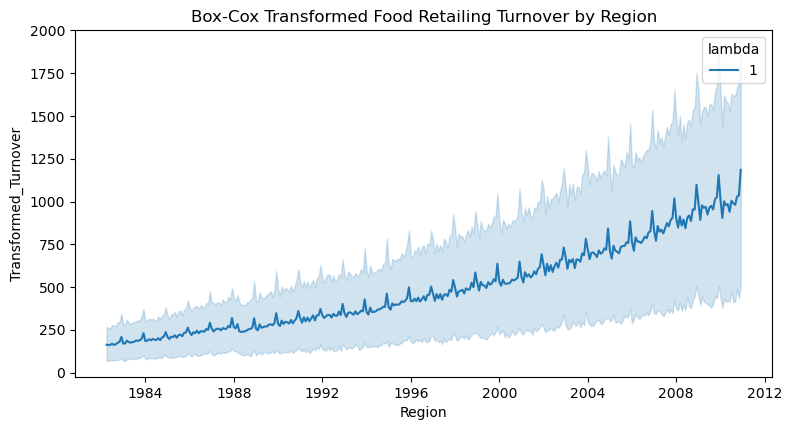

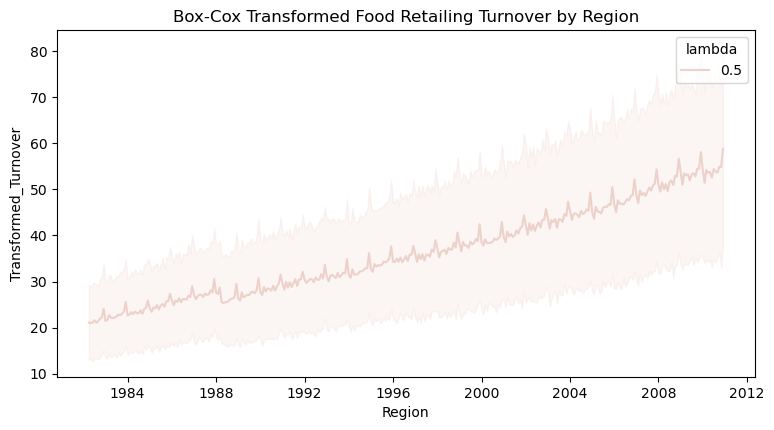

In [5]:
plt.figure(figsize=(9, 4.5))
sns.lineplot(data=transformed_df, x='Region', y='Transformed_Turnover', hue='lambda')
plt.title('Box-Cox Transformed Food Retailing Turnover by Region')
plt.show()

plt.figure(figsize=(9, 4.5))
sns.lineplot(data=transformed_df2, x='Region', y='Transformed_Turnover', hue='lambda')
plt.title('Box-Cox Transformed Food Retailing Turnover by Region')
plt.show()

## 예제 9-2. 시계열 분해 예시

### 미국 소매업 고용자 수 데이터 시계열 분해

#### 필요한 패키지 불러오기

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL

#### 데이터 전처리

In [7]:
us_employment = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.4/data/us_employment.csv')


us_retail_employment = us_employment[
    (pd.to_datetime(us_employment['Month']).dt.year >= 1975) & 
    (us_employment['Title'] == 'Retail Trade')
].drop(columns=['Series_ID'])

us_retail_employment['Month'] = pd.to_datetime(us_retail_employment['Month'])
us_retail_employment.set_index('Month', inplace=True)

us_retail_employment = us_retail_employment.asfreq('MS')

#### 데이터 시각화

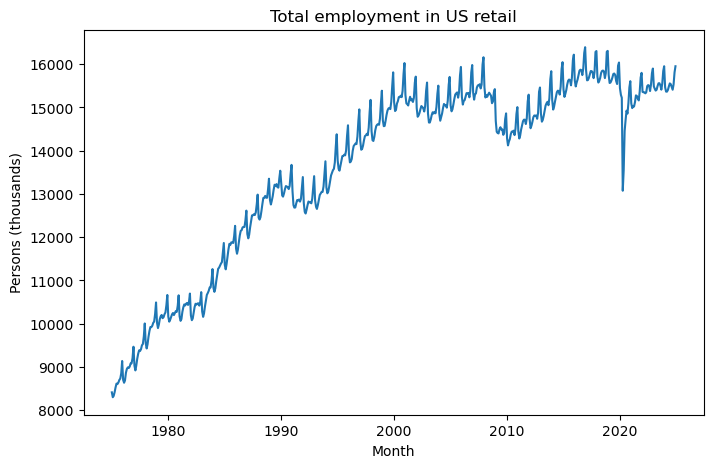

In [8]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=us_retail_employment, x='Month', y='Employed')
plt.ylabel('Persons (thousands)')
plt.title('Total employment in US retail')
plt.show()

#### STL 분해

In [9]:
stl = STL(us_retail_employment['Employed'], seasonal=13)
stl_result = stl.fit()

#### 분해 시각화

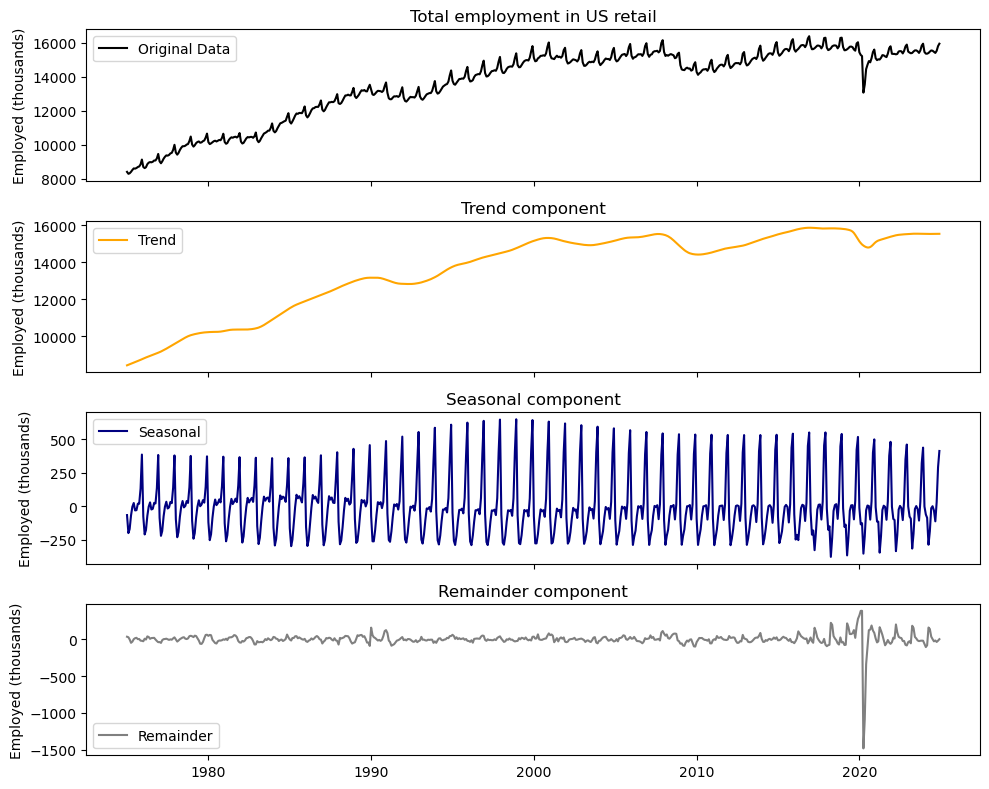

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8), sharex=True)

axes[0].plot(us_retail_employment['Employed'], label='Original Data', color='black')
axes[0].set_title('Total employment in US retail')

axes[1].plot(stl_result.trend, label='Trend', color='orange')
axes[1].set_title('Trend component')

axes[2].plot(stl_result.seasonal, label='Seasonal', color='navy')
axes[2].set_title('Seasonal component')

axes[3].plot(stl_result.resid, label='Remainder', color='grey')
axes[3].set_title('Remainder component')

for ax in axes:
    ax.set_ylabel('Employed (thousands)')
    ax.legend()

plt.tight_layout()
plt.show()

### 예제 9-3. 이동 평균 예시

### 호주 수출량 데이터 이동 평균을 통한 추세 제거

#### 필요한 패키지 불러오기

In [11]:
from statsmodels.tsa.filters.filtertools import recursive_filter

#### 데이터 전처리

In [12]:
global_economy = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.4/data/global_economy.csv')
global_economy['Year'] = pd.to_datetime(global_economy['Year'], format='%Y')
australia_exports = global_economy[global_economy['Country'] == 'Australia']

#### 데이터 시각화

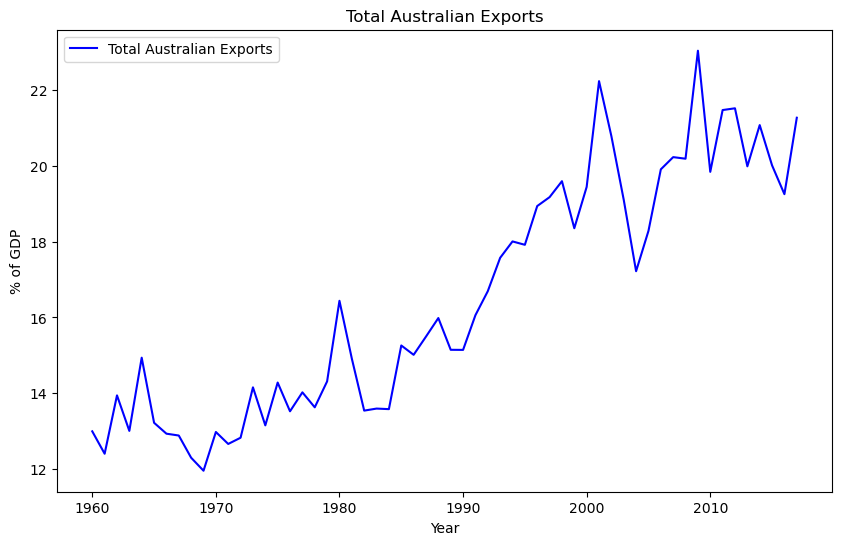

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(australia_exports['Year'], australia_exports['Exports'], label='Total Australian Exports', color='blue')
plt.xlabel('Year')
plt.ylabel('% of GDP')
plt.title('Total Australian Exports')
plt.legend()
plt.show()

#### 이동 평균 적용

In [14]:
def calculate_moving_average(data, window):
    return recursive_filter(data, [1/window]*window, init=None)

australia_exports = australia_exports.copy()
australia_exports['3-MA'] = australia_exports['Exports'].rolling(window=3, center=False).mean()
australia_exports['5-MA'] = australia_exports['Exports'].rolling(window=5, center=False).mean()
australia_exports['7-MA'] = australia_exports['Exports'].rolling(window=7, center=False).mean()

#### 시각화

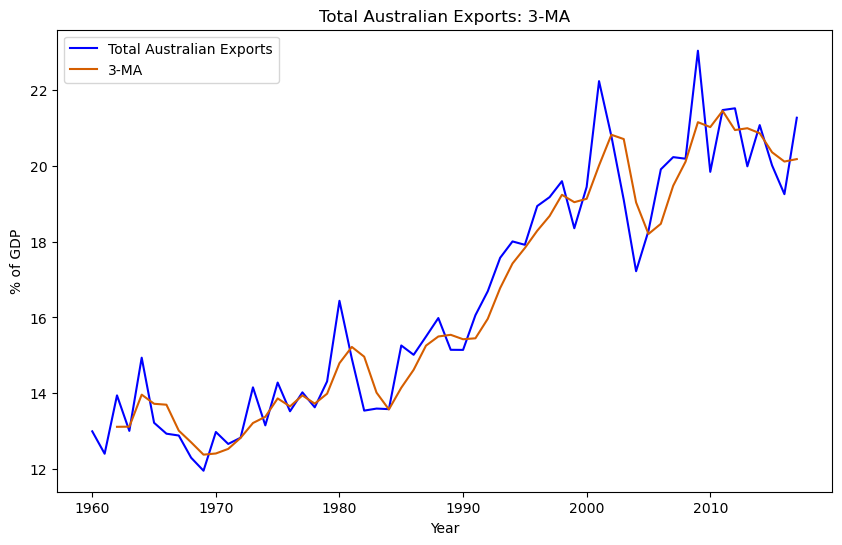

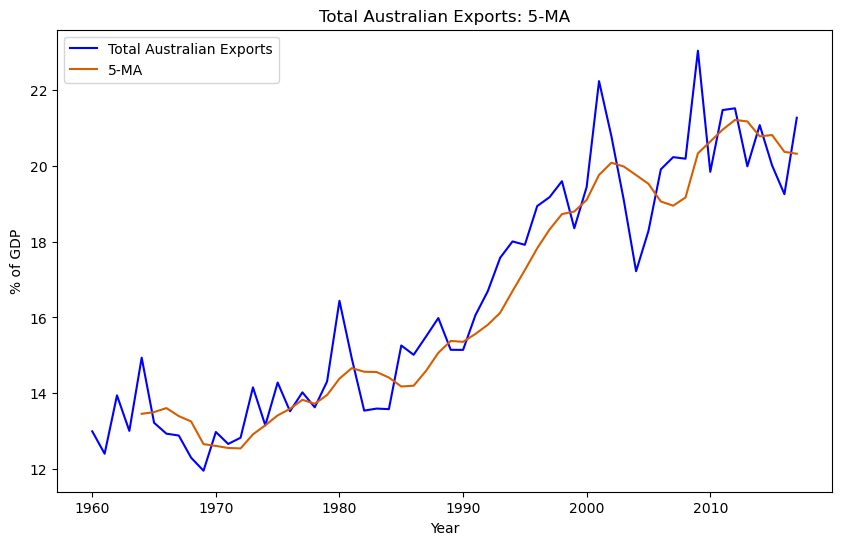

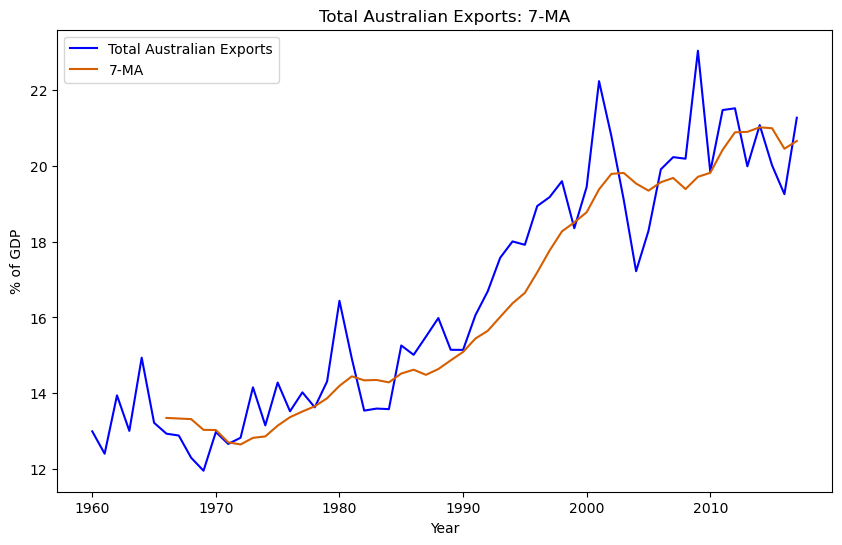

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(australia_exports['Year'], australia_exports['Exports'], label='Total Australian Exports', color='blue')
plt.plot(australia_exports['Year'], australia_exports['3-MA'], label='3-MA', color='#D55E00')
plt.xlabel('Year')
plt.ylabel('% of GDP')
plt.title('Total Australian Exports: 3-MA')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(australia_exports['Year'], australia_exports['Exports'], label='Total Australian Exports', color='blue')
plt.plot(australia_exports['Year'], australia_exports['5-MA'], label='5-MA', color='#D55E00')
plt.xlabel('Year')
plt.ylabel('% of GDP')
plt.title('Total Australian Exports: 5-MA')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(australia_exports['Year'], australia_exports['Exports'], label='Total Australian Exports', color='blue')
plt.plot(australia_exports['Year'], australia_exports['7-MA'], label='7-MA', color='#D55E00')
plt.xlabel('Year')
plt.ylabel('% of GDP')
plt.title('Total Australian Exports: 7-MA')
plt.legend()
plt.show()

## 3. 계절 조정

### 미국 소매업 고용자 수 계절 조정 그래프

#### 필요한 패키지 불러오기

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

#### STL 분해

In [17]:
stl = STL(us_retail_employment['Employed'], seasonal=13)
res = stl.fit()

#### 계절 조정

In [18]:
seasonal_df = us_retail_employment.copy()
seasonal_df['Month'] = seasonal_df.index.strftime('%b') 
seasonal_df['Year'] = seasonal_df.index.year
seasonal_df['Seasonal'] = res.seasonal

#### 시각화

<Figure size 2000x1200 with 0 Axes>

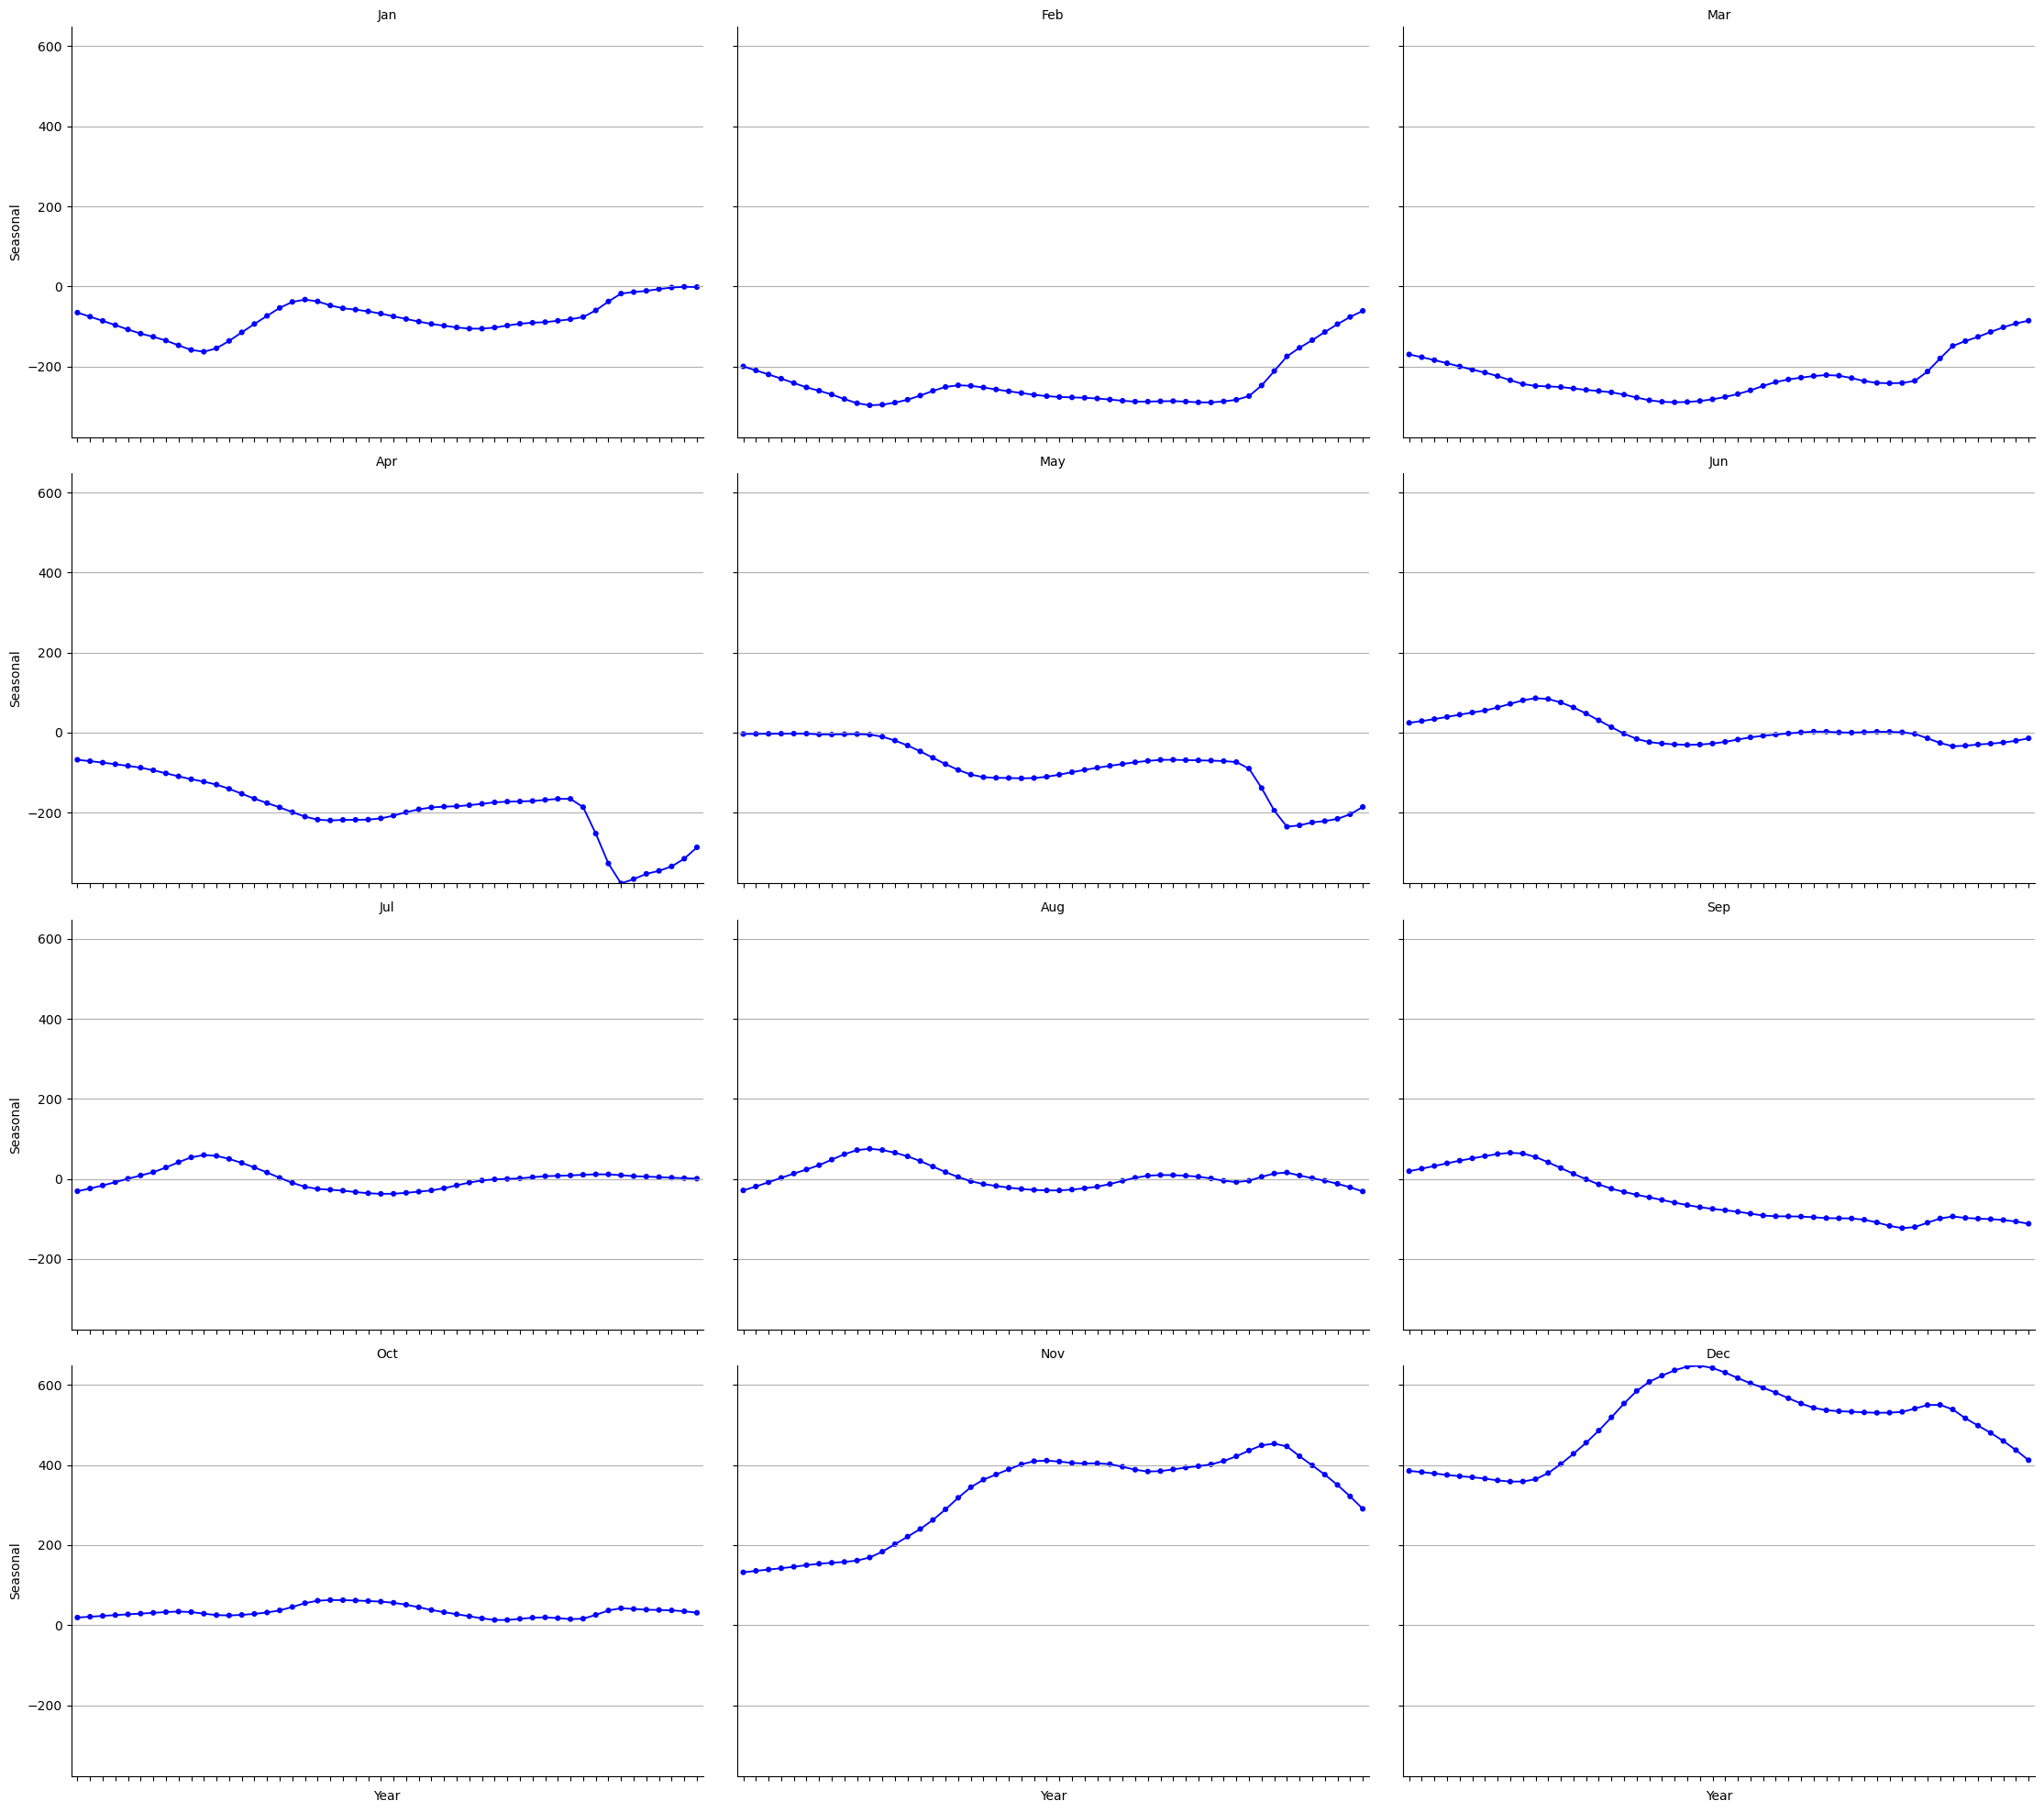

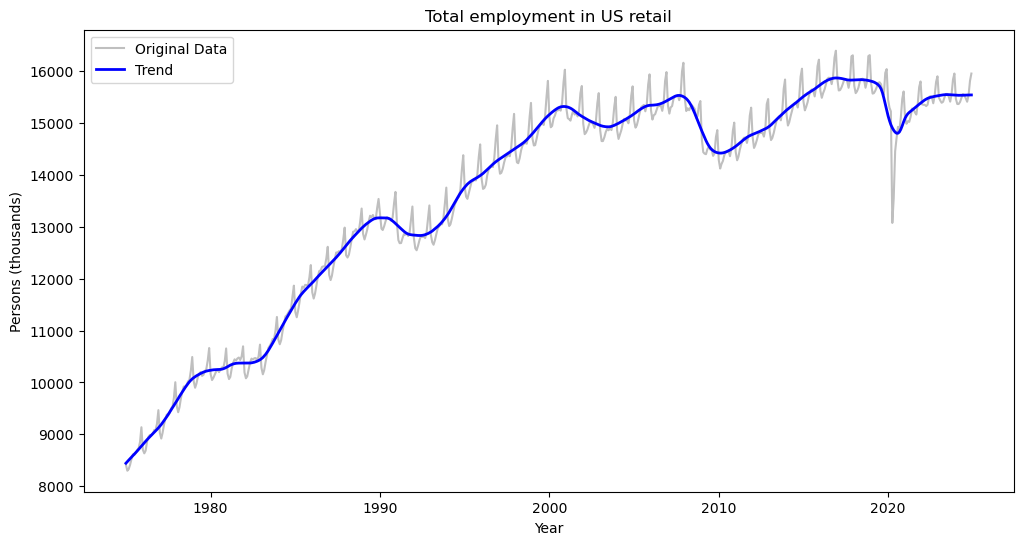

In [19]:
plt.figure(figsize=(20,12))
year_order = sorted(seasonal_df['Year'].unique())
g = sns.FacetGrid(seasonal_df, col="Month", col_wrap=3, sharey=True, aspect=1.5, height=5)

g = g.map(sns.pointplot, "Year", "Seasonal", color='blue', scale=0.5,order=year_order)

g.set(ylim=(seasonal_df['Seasonal'].min(), seasonal_df['Seasonal'].max()))

g.set_titles("{col_name}")
g.set_axis_labels("Year", "Seasonal")
g.set_xticklabels(rotation=90)

g.fig.set_facecolor('white')
for ax in g.axes.flatten():
    ax.yaxis.grid(True)  
    ax.xaxis.grid(False)

plt.figure(figsize=(12, 6))
plt.plot(us_retail_employment.index, us_retail_employment['Employed'], label='Original Data', color='grey', alpha=0.5)
plt.plot(us_retail_employment.index, res.trend, label='Trend', color='blue', linewidth=2)
plt.legend()
plt.title('Total employment in US retail')
plt.xlabel('Year')
plt.ylabel('Persons (thousands)')
plt.show()

## 예제 9-5. STL 분해 예시

## STL 분해

### 1) 소매 판매량 Loess 회귀

#### 필요한 패키지 불러오기

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

#### 데이터 불러오기

In [21]:
df = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.4/data/example_retail_sales.csv',parse_dates=['ds'], index_col='ds')
df['y'] = df['y'].replace({',': ''}, regex=True).astype(float)

#### Loess 데이터 시각화

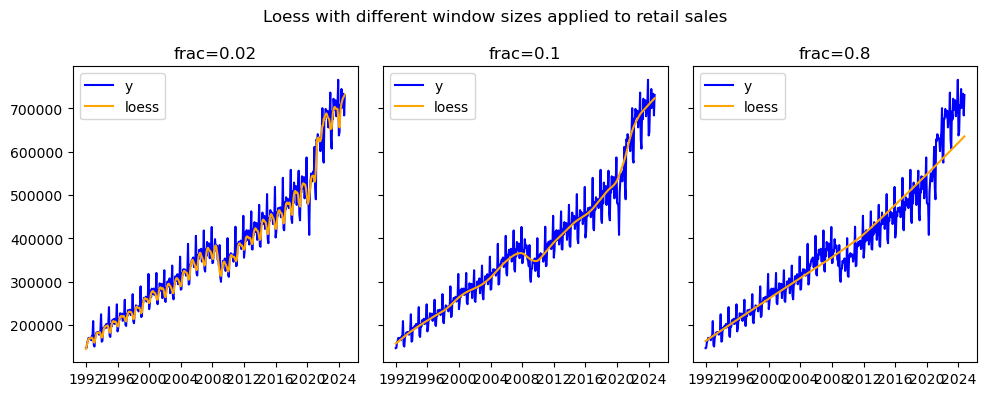

In [22]:
frac_values = [0.02, 0.1, 0.8]
fig, axes = plt.subplots(1, len(frac_values), figsize=(10, 4), sharey=True)

for ax, frac in zip(axes, frac_values):
    loess_result = lowess(df['y'], df.index, frac=frac)
    
    ax.plot(df.index, df['y'], label='y', color='blue')
    
    ax.plot(df.index, loess_result[:, 1], label='loess', color='orange')
    
    ax.set_title(f'frac={frac}')
    ax.legend()

plt.suptitle('Loess with different window sizes applied to retail sales')
plt.tight_layout()
plt.show()

### 2) 미국 소매업 고용자 수 STL 분해

#### 필요한 패키지 불러오기

In [23]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

#### 데이터 전처리

In [24]:
us_employment = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/refs/heads/main/Part.4/data/us_employment.csv')

us_retail_employment = us_employment[
    (pd.to_datetime(us_employment['Month']).dt.year >= 1975) & 
    (us_employment['Title'] == 'Retail Trade')
].drop(columns=['Series_ID'])

us_retail_employment['Month'] = pd.to_datetime(us_retail_employment['Month'])
us_retail_employment.set_index('Month', inplace=True)

#### STL 분해

In [25]:
stl = STL(us_retail_employment['Employed'])
result = stl.fit()

#### 시각화

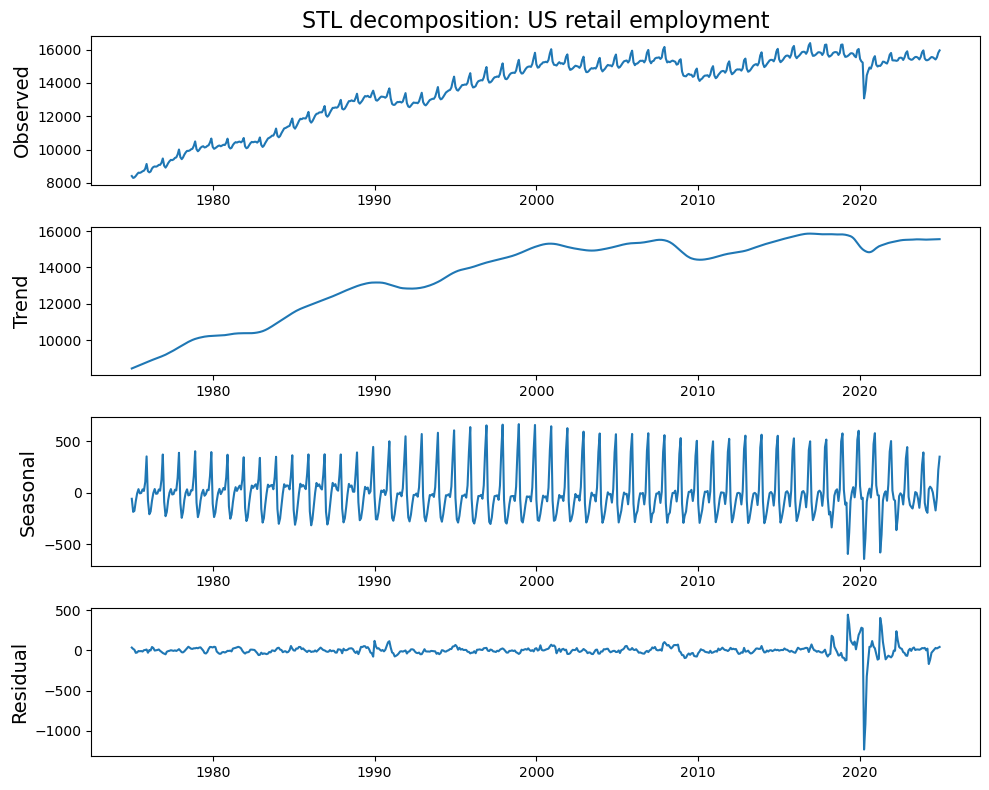

In [26]:
plt.figure(figsize=(10, 8))

ax1 = plt.subplot(411)
ax1.plot(result.observed)
ax1.set_title('STL decomposition: US retail employment', fontsize=16)
ax1.set_ylabel('Observed', fontsize=14)
            

ax2 = plt.subplot(412, sharex=ax1)
ax2.plot(result.trend)
ax2.set_ylabel('Trend', fontsize=14)

ax3 = plt.subplot(413, sharex=ax1)
ax3.plot(result.seasonal)
ax3.set_ylabel('Seasonal', fontsize=14)

ax4 = plt.subplot(414, sharex=ax1)
ax4.plot(result.resid)
ax4.set_ylabel('Residual', fontsize=14)

plt.tight_layout()
plt.show()

#### STL 분해 (추세창 75)

In [27]:
stl2 = STL(us_retail_employment['Employed'], trend = 75)
result2 = stl2.fit()

#### 시각화

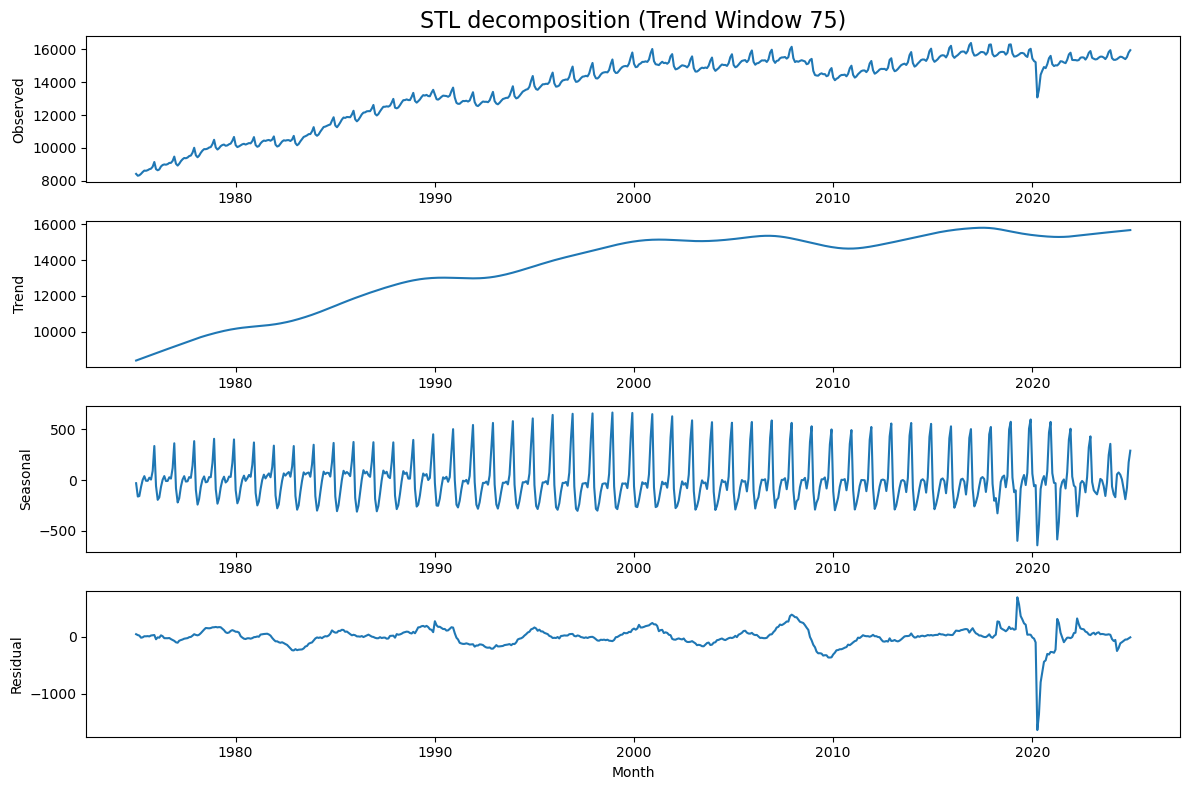

In [28]:
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(result2.observed)
plt.title('STL decomposition (Trend Window 75)', fontsize=16)
plt.ylabel('Observed')

plt.subplot(412)
plt.plot(result2.trend)
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(result2.seasonal)
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(result2.resid)
plt.ylabel('Residual')
plt.xlabel('Month')

plt.tight_layout()
plt.show()